# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

<b>Признаки</b>
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

<b>Целевой признак</b>
- Price — цена (евро)

In [1]:
pip install --upgrade scikit-learn

     |████████████████████████████████| 13.5 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 55.6 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
import time

## Подготовка данных

In [3]:
autos_data = pd.read_csv('/datasets/autos.csv')

In [4]:
def pretty_display(df, title="Таблица"):
    styled_df = df.head(5).style \
        .set_table_styles(
            [{'selector': 'th', 'props': [('text-align', 'center')]}]
        ) \
        .set_properties(**{'text-align': 'center'}) \
        .highlight_null(null_color='lightgray') \
        .set_caption(title)
    
    display(styled_df)

pretty_display(autos_data, "Первые 5 строк оригинальной таблицы")

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,nan,1993,manual,0,golf,150000,0,petrol,volkswagen,nan,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,nan,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
display(autos_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Типы данных не нарушены, стоит переименовать столбцы и привести их в нижний регистр.

In [6]:
autos_data.columns = (
    autos_data.columns
    .str.replace(r"([A-Z])", r" \1", regex=True)  # теперь явно
    .str.lower()
    .str.replace(' ', '_')
    .str[1:]
)
autos_data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [7]:
autos_data.duplicated().sum()

4

In [8]:
autos_data = autos_data.drop_duplicates()
autos_data.duplicated().sum()

0

Столбцы были преведены в нижний регист. Также были удалены дубликаты.

In [9]:
bad_features = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen']
report = []

for col in bad_features:
    unique_vals = autos_data[col].nunique()
    total_vals = autos_data[col].shape[0]
    unique_ratio = unique_vals / total_vals

    if autos_data[col].dtype in ['int64', 'float64']:
        corr = autos_data[['price', col]].corr().iloc[0, 1]
    else:
        codes = autos_data[col].astype('category').cat.codes.rename(col + "_codes")
        corr = autos_data[['price']].join(codes).corr().iloc[0, 1]

    report.append([col, unique_vals, f"{unique_ratio:.2%}", corr])

df_report = pd.DataFrame(report, columns=['Признак', 'Уникальных значений', 'Доля уникальных', 'Корреляция с price'])
df_report


,Признак,Уникальных значений,Доля уникальных,Корреляция с price
0,date_crawled,271174,76.52%,0.014923
1,price,3731,1.05%,1.000000
2,vehicle_type,8,0.00%,0.031139
3,registration_year,151,0.04%,0.026916
4,gearbox,2,0.00%,-0.080581
5,power,712,0.20%,0.158872
6,model,250,0.07%,0.005955
7,kilometer,13,0.00%,-0.333207
8,registration_month,13,0.00%,0.110580
9,fuel_type,7,0.00%,-0.097126


In [10]:
autos_data.drop(
    ['date_crawled', 'date_created', 'postal_code', 'number_of_pictures', 'last_seen'],
    axis=1,
    inplace=True
)
display(autos_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354365 non-null  int64 
 1   vehicle_type        316875 non-null  object
 2   registration_year   354365 non-null  int64 
 3   gearbox             334532 non-null  object
 4   power               354365 non-null  int64 
 5   model               334660 non-null  object
 6   kilometer           354365 non-null  int64 
 7   registration_month  354365 non-null  int64 
 8   fuel_type           321470 non-null  object
 9   brand               354365 non-null  object
 10  repaired            283211 non-null  object
dtypes: int64(5), object(6)
memory usage: 40.5+ MB


None

In [11]:
autos_data.duplicated().sum()

27539

In [12]:
autos_data = autos_data.drop_duplicates()
autos_data.duplicated().sum()

0

Была проведена повторая проверка на дубликаты, были удалены 27.5 тыс дубликатов.

Данные были очищены от ненужных признаков, так как они не коррелируют с целевым признаком:
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- NumberOfPictures — количество фотографий автомобиля
- last_seen - время последнего просмотра объявления

Данные признаки едва ли как либо коррелируют с целевым признаком Price — цена (евро).

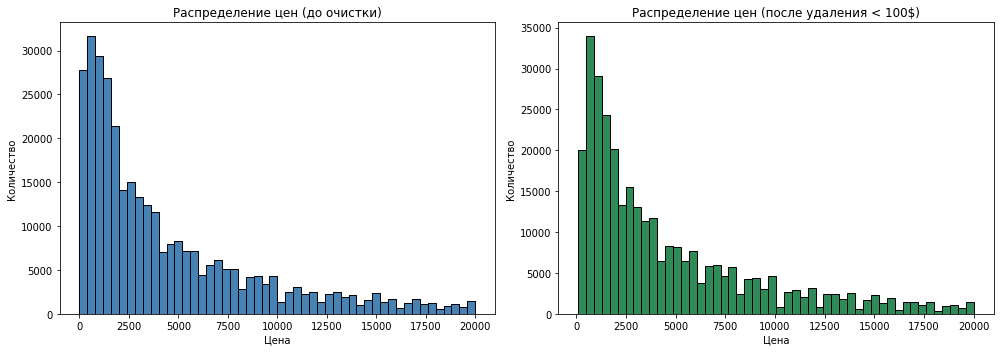

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

autos_data_raw = autos_data.copy() 
axes[0].hist(autos_data_raw['price'], bins=50, color='steelblue', edgecolor='black')
axes[0].set_title("Распределение цен (до очистки)")
axes[0].set_xlabel("Цена")
axes[0].set_ylabel("Количество")

autos_data = autos_data_raw[autos_data_raw['price'] > 100]
axes[1].hist(autos_data['price'], bins=50, color='seagreen', edgecolor='black')
axes[1].set_title("Распределение цен (после удаления < 100$)")
axes[1].set_xlabel("Цена")
axes[1].set_ylabel("Количество")

plt.tight_layout()
plt.show()

Были удалены значения меньше 100 долларов в целевом признаке. Для анализа данных стоит оставить только самые правдоподобные данные. 

In [14]:
autos_data.isna().sum()

price                     0
vehicle_type          30815
registration_year         0
gearbox               14539
power                     0
model                 16208
kilometer                 0
registration_month        0
fuel_type             26996
brand                     0
repaired              60097
dtype: int64

In [15]:
def fillna_and_unique(df, columns, fill_value="unknown"):
    result = {}
    for col in columns:
        df[col].fillna(fill_value, inplace=True)
        result[col] = df[col].unique()
    return result

In [16]:
cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
unique_values = fillna_and_unique(autos_data, cols)

for col, vals in unique_values.items():
    print(f"{col}: {vals}")

vehicle_type: ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
gearbox: ['manual' 'auto' 'unknown']
model: ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'other' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra'
 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo' 'focus' 'tt'
 'corsa' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 '

/opt/conda/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [17]:
autos_data.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

Столбцы которые имели пропуски были заполнены значение "unknown", 
    <b>['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']</b>. Так как это категориальные признаки, заполнить данные медианой не представляется возможным.

In [18]:
autos_data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1000,
       1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300,
       9000, 2900, 6000, 5900, 5911, 1400, 5000, 1950, 4000, 1948, 1952,
       8500, 1932, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 1923,
       2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928, 5555,
       5600, 1600, 1111, 1039, 1300, 2800, 1931, 4500, 1602, 7800, 1947,
       1927, 7100, 8200, 1946])

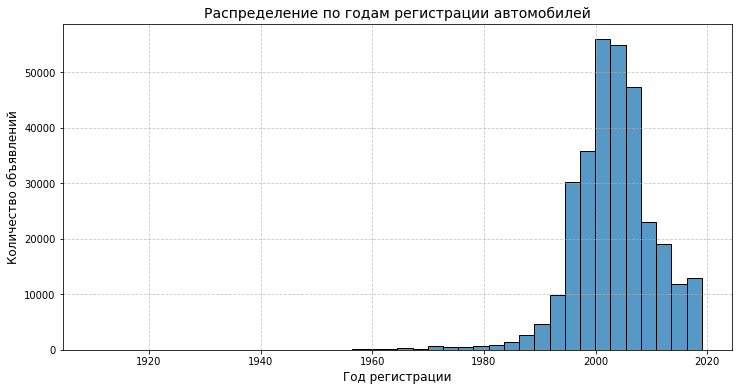

In [19]:
autos_year = autos_data[autos_data['registration_year'].between(1900, 2025)]

plt.figure(figsize=(12,6))
sns.histplot(autos_year['registration_year'], bins=40, kde=False)

plt.title("Распределение по годам регистрации автомобилей", fontsize=14)
plt.xlabel("Год регистрации", fontsize=12)
plt.ylabel("Количество объявлений", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


Следует оставить записи с 1990 по 2016 год, так как вывод уникальных значений показал неправдоподобные данные, которые могут значительно снизить качество модели.

In [20]:
autos_data = autos_data.query('1990 <= registration_year <= 2016')
autos_data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2016, 2007,
       2009, 2002, 1997, 1990, 2003, 1994, 1991, 2006, 1999, 2012, 2010,
       2000, 1992, 2013, 1996, 2015])

In [21]:
autos_data.power.describe()

count    292670.000000
mean        113.259237
std         188.255468
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [22]:
autos_data = autos_data[(autos_data['power'] >= 40) & (autos_data['power'] <= 400)]

print(autos_data['power'].describe())

count    264274.000000
mean        120.820206
std          52.162331
min          40.000000
25%          80.000000
50%         113.000000
75%         150.000000
max         400.000000
Name: power, dtype: float64


Столбец мощность двигателя следует удалить максимальные и минимальные значения, двигатель с 0 лс и 2000 лс выглядят неправдоподобно.

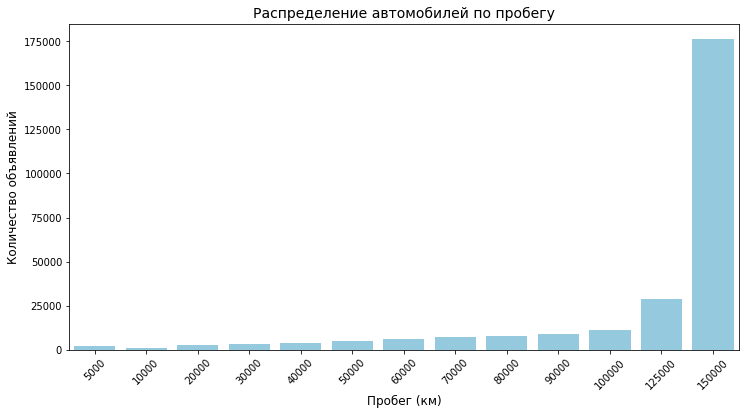

In [23]:
km_counts = autos_data['kilometer'].value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.barplot(x=km_counts.index, y=km_counts.values, color="skyblue")

plt.title("Распределение автомобилей по пробегу", fontsize=14)
plt.xlabel("Пробег (км)", fontsize=12)
plt.ylabel("Количество объявлений", fontsize=12)

plt.xticks(rotation=45)

plt.show()

Максимальные и минимальные значения в пробеге автомобилей не могут являтся ошибкой, данные признак стоит оставить как есть. Пробег сильно влияет на целевойпризнак.

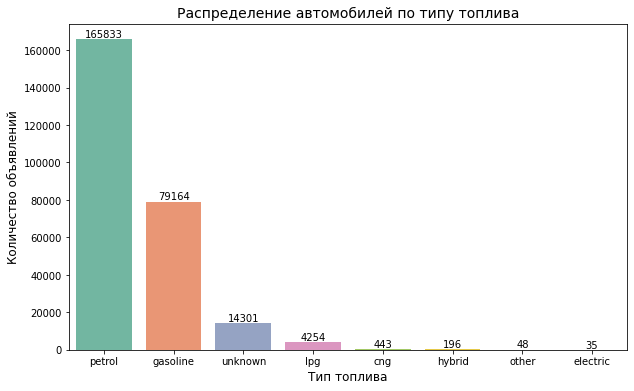

In [24]:
fuel_counts = autos_data['fuel_type'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=fuel_counts.index, y=fuel_counts.values, palette="Set2")

plt.title("Распределение автомобилей по типу топлива", fontsize=14)
plt.xlabel("Тип топлива", fontsize=12)
plt.ylabel("Количество объявлений", fontsize=12)

for i, v in enumerate(fuel_counts.values):
    plt.text(i, v + 1000, str(v), ha='center', fontsize=10)

plt.show()

В признаке fuel_type, тип топлива не обнаружено ошибок.

In [25]:
autos_data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


<b>Вывод по предобработке данных</b>
- Была проведена очистка данных от дубликатов и пропусков.
- Удалены лишние значения
- Данные были очищены от неактуальной информации и выбросов
- Название столбцов переведенов нижний регистр.

## Обучение моделей

In [26]:
X = autos_data.drop(columns=['price'])
y = autos_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_cols = ['registration_year', 'power', 'kilometer', 'registration_month']

X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test  = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [27]:
results = {}

param_grid = {"fit_intercept": [True, False]}
grid = GridSearchCV(
    LinearRegression(),
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5
)
grid.fit(X_train, y_train)

best_lr = grid.best_estimator_
best_rmse = -grid.best_score_

start_fit = time.time()
best_lr.fit(X_train, y_train)
end_fit = time.time()

start_pred = time.time()
_ = best_lr.predict(X_train)
end_pred = time.time()

results["LinearRegression"] = {
    "CV_RMSE": best_rmse,
    "Train_time": round(end_fit - start_fit, 4),
    "Pred_time": round(end_pred - start_pred, 6),
    "model": best_lr
}

In [28]:
hgb = HistGradientBoostingRegressor(
    max_depth=15,
    learning_rate=0.1,
    random_state=42
)

scores = cross_val_score(
    hgb, X_train, y_train,
    scoring='neg_root_mean_squared_error',
    cv=5, n_jobs=-1
)

start_fit = time.time()
hgb.fit(X_train, y_train)
end_fit = time.time()

start_pred = time.time()
_ = hgb.predict(X_train)
end_pred = time.time()

results["HistGradientBoosting"] = {
    "CV_RMSE": -scores.mean(),
    "Train_time": round(end_fit - start_fit, 4),
    "Pred_time": round(end_pred - start_pred, 6),
    "model": hgb
}

In [29]:
lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(
    lgbm, X_train, y_train,
    scoring='neg_root_mean_squared_error',
    cv=5, n_jobs=-1
)

start_fit = time.time()
lgbm.fit(X_train, y_train)
end_fit = time.time()

start_pred = time.time()
_ = lgbm.predict(X_train)
end_pred = time.time()

results["LightGBM"] = {
    "CV_RMSE": -scores.mean(),
    "Train_time": round(end_fit - start_fit, 4),
    "Pred_time": round(end_pred - start_pred, 6),
    "model": lgbm
}

In [30]:
best_model_name = min(results, key=lambda x: results[x]["CV_RMSE"])
best_model = results[best_model_name]["model"]

print("\n Результаты промежуточной оценки (CV):")
for name, res in results.items():
    print(f"{name}: RMSE={res['CV_RMSE']:.2f}, "
          f"Train={res['Train_time']} сек, "
          f"Pred={res['Pred_time']} сек")


y_pred = best_model.predict(X_test)
final_rmse = np.sqrt(((y_test - y_pred) ** 2).mean())

print(f"\n Лучшая модель: {best_model_name}")
print("Финальный тест RMSE:", round(final_rmse, 2))



 Результаты промежуточной оценки (CV):
LinearRegression: RMSE=2277.40, Train=18.8001 сек, Pred=0.397809 сек
HistGradientBoosting: RMSE=1566.92, Train=51.3684 сек, Pred=2.966975 сек
LightGBM: RMSE=1511.04, Train=21.2117 сек, Pred=9.819398 сек

 Лучшая модель: LightGBM
Финальный тест RMSE: 1518.21


## Анализ моделей

- Наиболее сбалансированной себя показала модель LGBMRegressor, почти не уступая во времени обучения LinearRegression она в отличии от нее показала RMSE 1550 баллов против 2300 у LinearRegression.
- ExtraTreesRegressor - тоже показала себя отлично, но обучение данной модели заняло больше времени, если клиенту важна скорость и точность, его выбор это LGBMRegressor.